## Smart Traffic: A data-driven approach to predicting congestion level in smart cities.

In [172]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report 

from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
import pickle


import warnings
warnings.filterwarnings('ignore')

# !pip install folium
# !pip install shapely
# !pip install yellowbrick

import folium
from shapely.geometry import Polygon, Point

## I. Exploratory Data Analysis

### Preparing and preprocessing data

In [2]:
chicago_data = pd.read_csv("./chicago_data/Congestion_Estimates_by_Region_2018-Current.csv")
chicago_data

,TIME,REGION_ID,SPEED,REGION,BUS_COUNT,NUM_READS,HOUR,DAY_OF_WEEK,MONTH,DESCRIPTION,RECORD_ID,WEST,EAST,SOUTH,NORTH,NW_LOCATION,SE_LOCATION
0,03/31/2018 02:40:28 PM,2,27.95,Far North West,25,493,14,7,3,North of Montrose. East River to Cicero,02-201803311940,-87.846210,-87.747456,41.960669,42.019100,POINT (-87.84621 42.0190998),POINT (-87.747456 41.960669)
1,03/31/2018 02:40:28 PM,3,19.09,North Park-Albany-Linconl Sq,48,834,14,7,3,Montrose to Devon. Cicero to Ravenswood,03-201803311940,-87.747456,-87.674590,41.960669,41.997946,POINT (-87.747456 41.997946),POINT (-87.67459 41.960669)
2,03/31/2018 02:40:28 PM,4,18.41,Edge Water-Uptown,36,585,14,7,3,Montrose to Devon. Ravenswood to Lake Shore,04-201803311940,-87.674590,-87.646438,41.960669,41.997946,POINT (-87.67459 41.997946),POINT (-87.646438 41.960669)
3,03/31/2018 02:40:28 PM,6,20.45,Irving Park-Avondale-North Ctr,48,811,14,7,3,Diversey to Montrose. Cicero to Ravenswood,06-201803311940,-87.747456,-87.674590,41.931841,41.960669,POINT (-87.747456 41.960669),POINT (-87.67459 41.931841)
4,03/31/2018 02:40:28 PM,7,18.41,Hermosa-Logan Square,47,817,14,7,3,North Ave to Diversy. Cicero to Ravenswood,07-201803311940,-87.747456,-87.674590,41.909269,41.931841,POINT (-87.747456 41.931841),POINT (-87.67459 41.909269)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6828942,02/13/2023 11:40:33 PM,24,26.59,South Shore-S Chicago-Avlon,20,520,23,2,2,91st to 71st. Cottage Grove to Lake Shore,24-202302140540,-87.606334,-87.526388,41.728472,41.764066,POINT (-87.606334 41.764066),POINT (-87.526388 41.728472)
6828943,02/13/2023 11:40:33 PM,9,27.95,Austin,12,246,23,2,2,Roosevelt to North Ave. Austin to Cicero,09-202302140540,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
6828944,02/13/2023 11:40:33 PM,20,25.91,Fuller-Grand Blvd-Washington Park,17,494,23,2,2,71st to Pershing. Steward to Cottage Grove,20-202302140540,-87.636322,-87.606334,41.764066,41.822792,POINT (-87.636322 41.822792),POINT (-87.606334 41.764066)
6828945,02/13/2023 11:40:33 PM,5,27.27,Dunning-Portage-Belmont Cragn,19,499,23,2,2,North Ave to Montrose. East River to Cicero,05-202302140540,-87.846210,-87.747456,41.909269,41.960669,POINT (-87.84621 41.960669),POINT (-87.747456 41.909269)


In [3]:
chicago_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6828947 entries, 0 to 6828946
Data columns (total 17 columns):
 #   Column       Dtype  
---  ------       -----  
 0   TIME         object 
 1   REGION_ID    int64  
 2   SPEED        float64
 3   REGION       object 
 4   BUS_COUNT    int64  
 5   NUM_READS    int64  
 6   HOUR         int64  
 7   DAY_OF_WEEK  int64  
 8   MONTH        int64  
 9   DESCRIPTION  object 
 10  RECORD_ID    object 
 11  WEST         float64
 12  EAST         float64
 13  SOUTH        float64
 14  NORTH        float64
 15  NW_LOCATION  object 
 16  SE_LOCATION  object 
dtypes: float64(5), int64(6), object(6)
memory usage: 885.7+ MB


In [4]:
#coverting dates to date time objects
chicago_data["TIME"] = pd.to_datetime(chicago_data["TIME"])
chicago_data

,TIME,REGION_ID,SPEED,REGION,BUS_COUNT,NUM_READS,HOUR,DAY_OF_WEEK,MONTH,DESCRIPTION,RECORD_ID,WEST,EAST,SOUTH,NORTH,NW_LOCATION,SE_LOCATION
0,2018-03-31 14:40:28,2,27.95,Far North West,25,493,14,7,3,North of Montrose. East River to Cicero,02-201803311940,-87.846210,-87.747456,41.960669,42.019100,POINT (-87.84621 42.0190998),POINT (-87.747456 41.960669)
1,2018-03-31 14:40:28,3,19.09,North Park-Albany-Linconl Sq,48,834,14,7,3,Montrose to Devon. Cicero to Ravenswood,03-201803311940,-87.747456,-87.674590,41.960669,41.997946,POINT (-87.747456 41.997946),POINT (-87.67459 41.960669)
2,2018-03-31 14:40:28,4,18.41,Edge Water-Uptown,36,585,14,7,3,Montrose to Devon. Ravenswood to Lake Shore,04-201803311940,-87.674590,-87.646438,41.960669,41.997946,POINT (-87.67459 41.997946),POINT (-87.646438 41.960669)
3,2018-03-31 14:40:28,6,20.45,Irving Park-Avondale-North Ctr,48,811,14,7,3,Diversey to Montrose. Cicero to Ravenswood,06-201803311940,-87.747456,-87.674590,41.931841,41.960669,POINT (-87.747456 41.960669),POINT (-87.67459 41.931841)
4,2018-03-31 14:40:28,7,18.41,Hermosa-Logan Square,47,817,14,7,3,North Ave to Diversy. Cicero to Ravenswood,07-201803311940,-87.747456,-87.674590,41.909269,41.931841,POINT (-87.747456 41.931841),POINT (-87.67459 41.909269)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6828942,2023-02-13 23:40:33,24,26.59,South Shore-S Chicago-Avlon,20,520,23,2,2,91st to 71st. Cottage Grove to Lake Shore,24-202302140540,-87.606334,-87.526388,41.728472,41.764066,POINT (-87.606334 41.764066),POINT (-87.526388 41.728472)
6828943,2023-02-13 23:40:33,9,27.95,Austin,12,246,23,2,2,Roosevelt to North Ave. Austin to Cicero,09-202302140540,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
6828944,2023-02-13 23:40:33,20,25.91,Fuller-Grand Blvd-Washington Park,17,494,23,2,2,71st to Pershing. Steward to Cottage Grove,20-202302140540,-87.636322,-87.606334,41.764066,41.822792,POINT (-87.636322 41.822792),POINT (-87.606334 41.764066)
6828945,2023-02-13 23:40:33,5,27.27,Dunning-Portage-Belmont Cragn,19,499,23,2,2,North Ave to Montrose. East River to Cicero,05-202302140540,-87.846210,-87.747456,41.909269,41.960669,POINT (-87.84621 41.960669),POINT (-87.747456 41.909269)


In [5]:
#dropping irrelevant columns
chicago_data.drop(["DESCRIPTION","RECORD_ID","NW_LOCATION","SE_LOCATION"], axis=1, inplace=True)

In [6]:
#selecting data from 2020 to latest
chicago_data.set_index("TIME", inplace=True)
chicago_data = chicago_data.sort_index()
chicago_2022 = chicago_data[chicago_data.index >= "2022-01-01"]
chicago_2022

,REGION_ID,SPEED,REGION,BUS_COUNT,NUM_READS,HOUR,DAY_OF_WEEK,MONTH,WEST,EAST,SOUTH,NORTH
TIME,,,,,,,,,,,,
2022-01-01 00:01:21,15,33.41,Bridgeport-McKinley-Lower West,8,218,0,7,1,-87.685372,-87.636322,41.822792,41.866129
2022-01-01 00:01:21,21,30.31,Hyde Park-Kenwood-Woodlawn,9,232,0,7,1,-87.606334,-87.566260,41.764066,41.822792
2022-01-01 00:01:21,2,0.00,Far North West,2,42,0,7,1,-87.846210,-87.747456,41.960669,42.019100
2022-01-01 00:01:21,6,26.59,Irving Park-Avondale-North Ctr,8,235,0,7,1,-87.747456,-87.674590,41.931841,41.960669
2022-01-01 00:01:21,29,0.68,Downtown Lakefront,27,496,0,7,1,-87.623080,-87.595378,41.866129,41.911401
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-05 02:10:26,28,0.00,Riverdale-Hegewisch,2,64,2,1,3,-87.662508,-87.524436,41.644139,41.677477
2023-03-05 02:10:26,26,39.55,Washington Hts-Roseland-Pullman,7,169,2,1,3,-87.662508,-87.584845,41.677477,41.728472
2023-03-05 02:10:26,25,0.00,Beverly-Mt Greenwood-Morgan Park,1,7,2,1,3,-87.747456,-87.662508,41.677477,41.728472


In [7]:
chicago_2022.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1532029 entries, 2022-01-01 00:01:21 to 2023-03-05 02:10:26
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   REGION_ID    1532029 non-null  int64  
 1   SPEED        1532029 non-null  float64
 2   REGION       1532029 non-null  object 
 3   BUS_COUNT    1532029 non-null  int64  
 4   NUM_READS    1532029 non-null  int64  
 5   HOUR         1532029 non-null  int64  
 6   DAY_OF_WEEK  1532029 non-null  int64  
 7   MONTH        1532029 non-null  int64  
 8   WEST         1532029 non-null  float64
 9   EAST         1532029 non-null  float64
 10  SOUTH        1532029 non-null  float64
 11  NORTH        1532029 non-null  float64
dtypes: float64(5), int64(6), object(1)
memory usage: 151.9+ MB


In [8]:
#missing values
chicago_2022.isnull().sum()

REGION_ID      0
SPEED          0
REGION         0
BUS_COUNT      0
NUM_READS      0
HOUR           0
DAY_OF_WEEK    0
MONTH          0
WEST           0
EAST           0
SOUTH          0
NORTH          0
dtype: int64

In [9]:
#summary statistics
chicago_2022.describe()

,REGION_ID,SPEED,BUS_COUNT,NUM_READS,HOUR,DAY_OF_WEEK,MONTH,WEST,EAST,SOUTH,NORTH
count,1.532029e+06,1.532029e+06,1.532029e+06,1.532029e+06,1.532029e+06,1.532029e+06,1.532029e+06,1.532029e+06,1.532029e+06,1.532029e+06,1.532029e+06
mean,1.500000e+01,2.387725e+01,3.060588e+01,6.574466e+02,1.148586e+01,4.015963e+00,5.318012e+00,-8.770191e+01,-8.764235e+01,4.182452e+01,4.186771e+01
std,8.366639e+00,8.588285e+00,2.254718e+01,4.811013e+02,6.927666e+00,1.997972e+00,3.368335e+00,6.766015e-02,6.250795e-02,9.740247e-02,9.437720e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-8.784621e+01,-8.774746e+01,4.164414e+01,4.167748e+01
25%,8.000000e+00,2.250000e+01,1.300000e+01,2.630000e+02,5.000000e+00,2.000000e+00,2.000000e+00,-8.774746e+01,-8.767459e+01,4.176407e+01,4.182279e+01
50%,1.500000e+01,2.591000e+01,2.600000e+01,5.670000e+02,1.100000e+01,4.000000e+00,5.000000e+00,-8.768537e+01,-8.764644e+01,4.182279e+01,4.186613e+01
75%,2.200000e+01,2.864000e+01,4.400000e+01,9.700000e+02,1.700000e+01,6.000000e+00,8.000000e+00,-8.764721e+01,-8.760633e+01,4.190927e+01,4.193184e+01
max,2.900000e+01,1.738600e+02,1.710000e+02,3.253000e+03,2.300000e+01,7.000000e+00,1.200000e+01,-8.758485e+01,-8.752444e+01,4.199795e+01,4.202644e+01


In [10]:
#missing values for some traffic regions for different timestamps
chicago_2022["REGION_ID"].value_counts()

1     52830
2     52830
29    52830
22    52830
21    52830
13    52829
27    52829
24    52829
4     52829
5     52829
3     52829
25    52829
26    52829
14    52829
10    52829
8     52828
19    52828
11    52828
23    52828
15    52828
12    52828
9     52828
18    52828
28    52828
7     52828
6     52828
20    52828
16    52827
17    52826
Name: REGION_ID, dtype: int64

### Visualizations

#### Visualizing the Speed variable

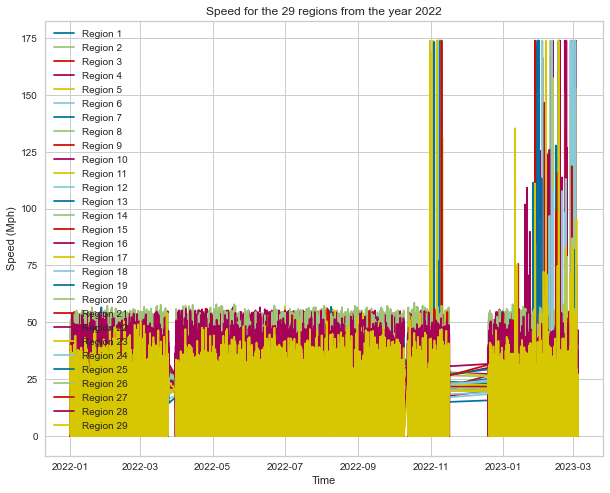

In [12]:
#visualizing speed variation over time
speed_groups = chicago_2022.groupby("REGION_ID")

plt.figure(figsize=(10,8))
plt.title("Speed for the 29 regions from the year 2022")

for region in sorted(chicago_2022["REGION_ID"].unique()):
    x = speed_groups.get_group(region)
    plt.plot(x["SPEED"], label=f"Region {region}")

plt.ylabel("Speed (Mph)")
plt.xlabel("Time")
plt.legend()
plt.show()

> For visualization and analysis purposes, only 3 regions will be selected (Regions 6,19,29), and only from the year 2022

In [13]:
#selecting the regions
region_6 = speed_groups.get_group(6)
region_6 = region_6[region_6.index >= "2022-01-01"]

region_28 = speed_groups.get_group(28)
region_28 = region_28[region_28.index >= "2022-01-01"]

region_29 = speed_groups.get_group(29)
region_29 = region_29[region_29.index >= "2022-01-01"]

##### Speed distributions

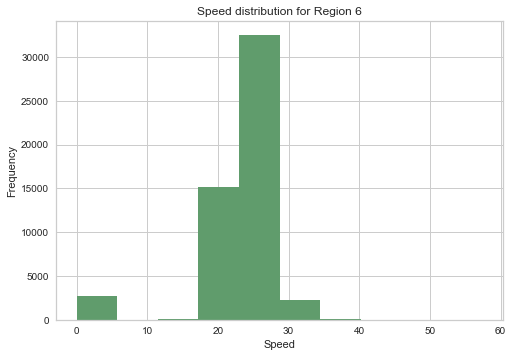

In [20]:
#region 6
plt.title("Speed distribution for Region 6")
region_6["SPEED"].hist(color="#609c6c")
plt.xlabel("Speed")
plt.ylabel("Frequency")
plt.show()

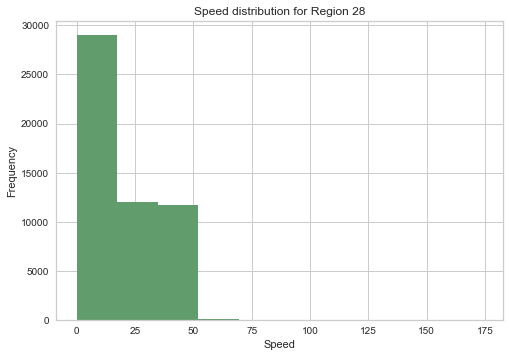

In [21]:
#region 28
plt.title("Speed distribution for Region 28")
region_28["SPEED"].hist(color="#609c6c")
plt.xlabel("Speed")
plt.ylabel("Frequency")
plt.show()

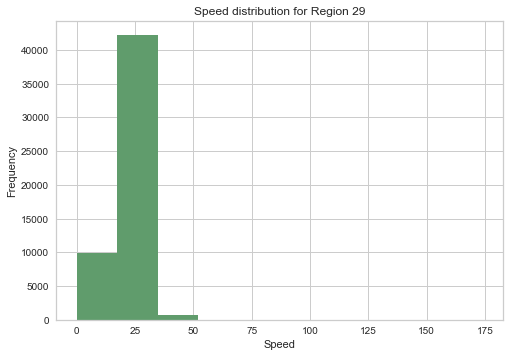

In [22]:
#region 29
plt.title("Speed distribution for Region 29")
region_29["SPEED"].hist(color="#609c6c")
plt.xlabel("Speed")
plt.ylabel("Frequency")
plt.show()

##### Traffic patterns for different hours of the day

In [23]:
def plot_speed_averages(region, frequency, n):
    averages=[]
    if frequency=='Hourly':
        groups = region.groupby('HOUR')
        ranges = np.arange(0,24)
        for i in ranges:
            avg = groups.get_group(i).SPEED.mean()
            averages.append(avg)
        xlabel="Hours"
    else:
        groups = region.groupby('DAY_OF_WEEK')
        ranges = np.arange(1,8)
        for i in ranges:
            avg = groups.get_group(i).SPEED.mean()
            averages.append(avg)
        xlabel="Days"

    plt.figure(figsize=(10,8))
    plt.title(f"{frequency} average speeds in Region {n}")
    sns.barplot(x=ranges, y=averages, color="#609c6c")
    plt.xlabel(xlabel)
    plt.ylabel("Average speed")
    plt.show()

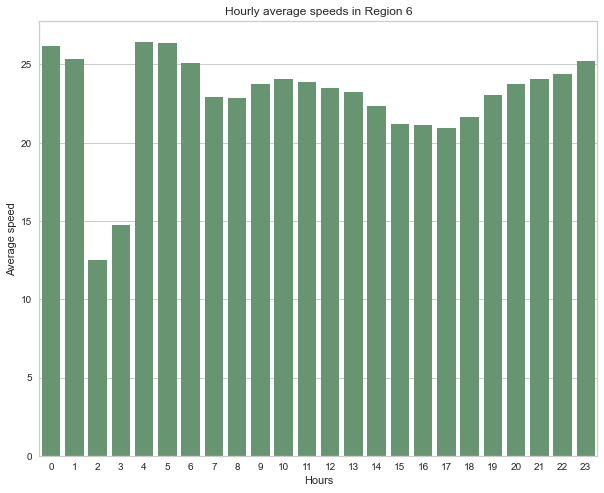

In [24]:
#hourly averages for region 6
plot_speed_averages(region_6, 'Hourly', 6)

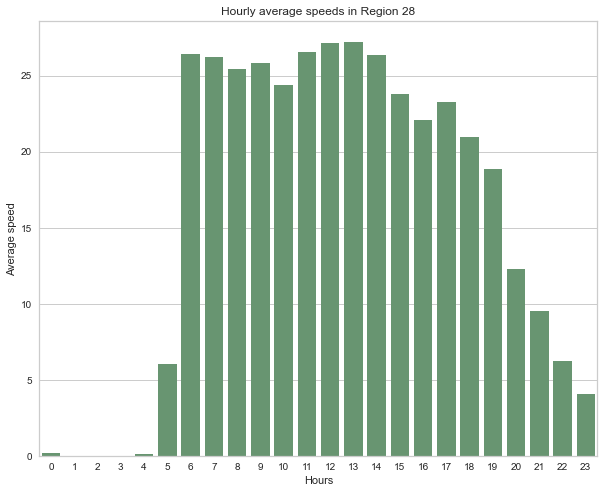

In [25]:
#hourly averages for region 28
plot_speed_averages(region_28, 'Hourly', 28)

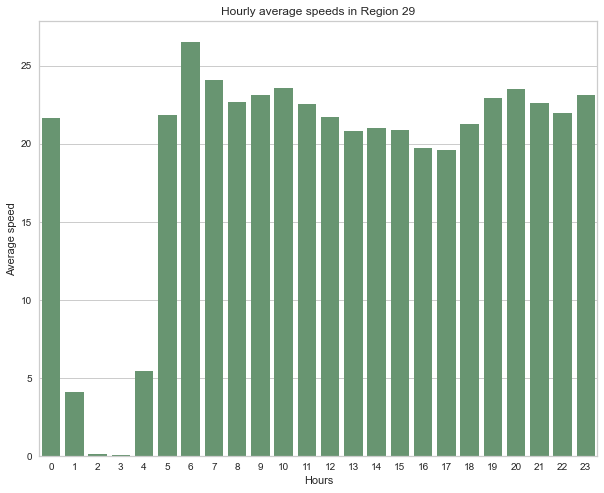

In [26]:
#hourly averages for region 29
plot_speed_averages(region_29, 'Hourly', 29)

##### Traffic patterns for different days of the week

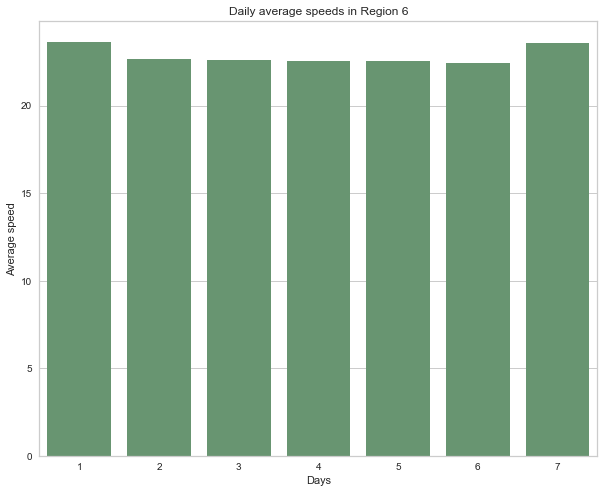

In [27]:
#daily averages for region 6
plot_speed_averages(region_6, 'Daily', 6)

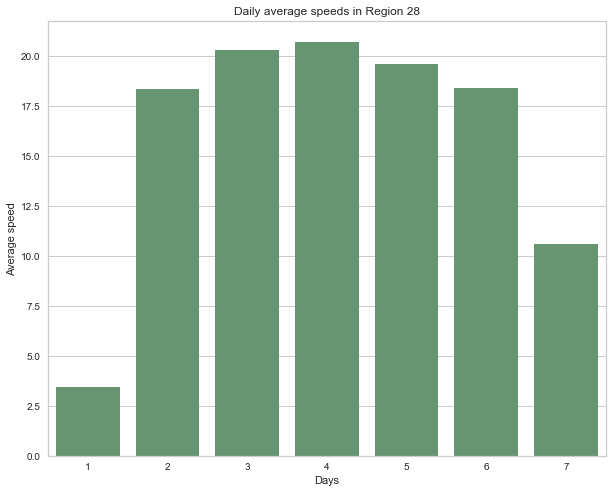

In [28]:
#daily averages for region 28
plot_speed_averages(region_28, 'Daily', 28)

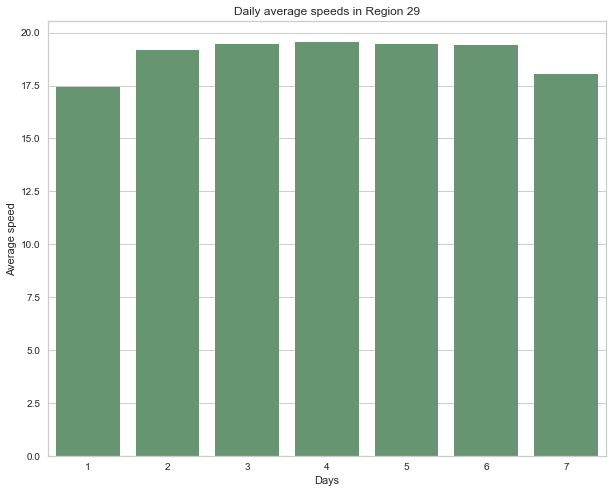

In [29]:
#daily averages for region 29
plot_speed_averages(region_29, 'Daily', 29)

##### Traffic patterns for all hours in each day of the week

In [30]:
#Function to compute hourly and daily averages 
def day_hour(region):
    day_hour_groups = region.groupby([region.DAY_OF_WEEK, region.HOUR])
    day_hour_averages = []
    for i in range(1,8):
        day = []
        for j in range(0,24):
            avg = day_hour_groups.get_group((i,j))["SPEED"].mean()
            day.append(avg)
        day_hour_averages.append(day)

    return day_hour_averages

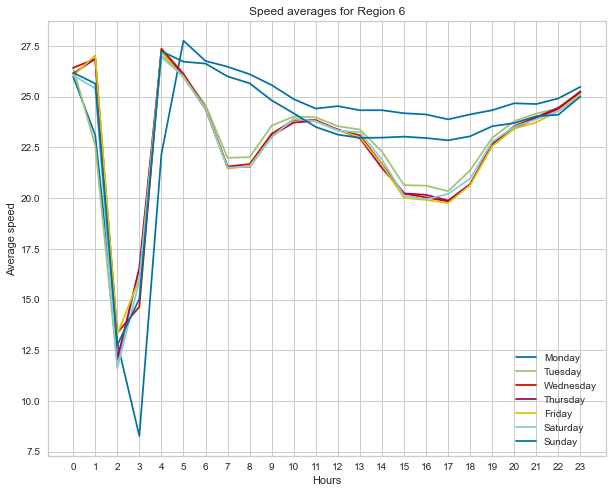

In [31]:
#computing hourly-daily averages for each region
region6_avg = day_hour(region_6)
region28_avg = day_hour(region_28)
region29_avg = day_hour(region_29)

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#Region 6
plt.figure(figsize=(10,8))
plt.title("Speed averages for Region 6")

for day,speed in zip(days,region6_avg):
    plt.plot(np.arange(0,24), speed, label=day)
    
plt.xticks(np.arange(0,24))
plt.xlabel("Hours")
plt.ylabel("Average speed")
plt.legend()
plt.show()

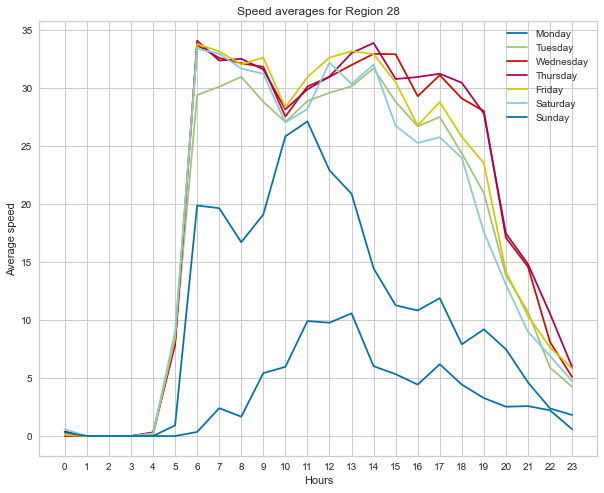

In [32]:
#Region 28
plt.figure(figsize=(10,8))
plt.title("Speed averages for Region 28")

for day,speed in zip(days,region28_avg):
    plt.plot(np.arange(0,24), speed, label=day)
    
plt.xticks(np.arange(0,24))
plt.xlabel("Hours")
plt.ylabel("Average speed")
plt.legend()
plt.show()

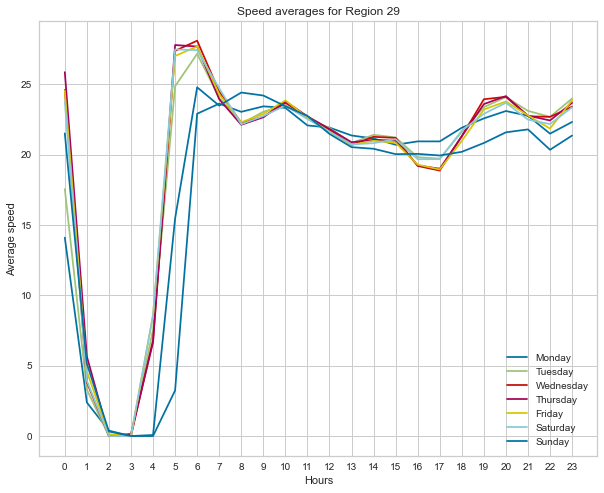

In [33]:
#Region 29
plt.figure(figsize=(10,8))
plt.title("Speed averages for Region 29")

for day,speed in zip(days,region29_avg):
    plt.plot(np.arange(0,24), speed, label=day)
    
plt.xticks(np.arange(0,24))
plt.xlabel("Hours")
plt.ylabel("Average speed")
plt.legend()
plt.show()

##### Traffic patterns for all months

In [34]:
#computing the average for each month
def plot_monthly_averages(region, n):
    monthly_averages = region["SPEED"].resample("M").mean()
    
    #plotting the monthly averages
    plt.figure(figsize=(10,8))
    plt.title(f"Monthly Average Speed for Region {n}")
    plt.bar(monthly_averages.index, monthly_averages, width=15, color="#609c6c")
    plt.xticks(monthly_averages.index, rotation=45)
    plt.xlabel("Months")
    plt.ylabel("Average speed")
    plt.show()

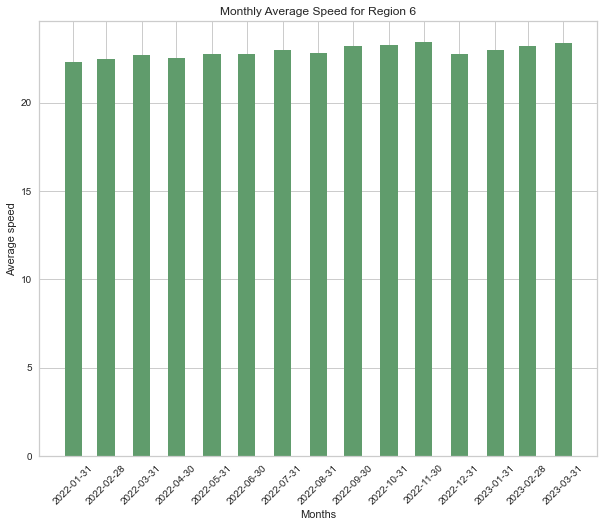

In [35]:
#region 6
plot_monthly_averages(region_6, 6)

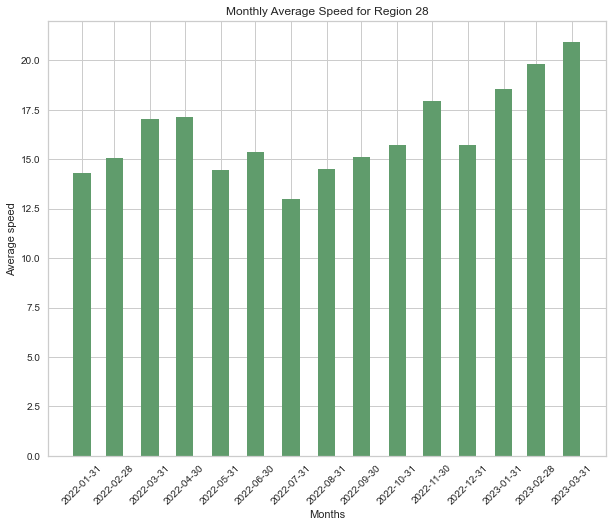

In [36]:
#region 28
plot_monthly_averages(region_28, 28)

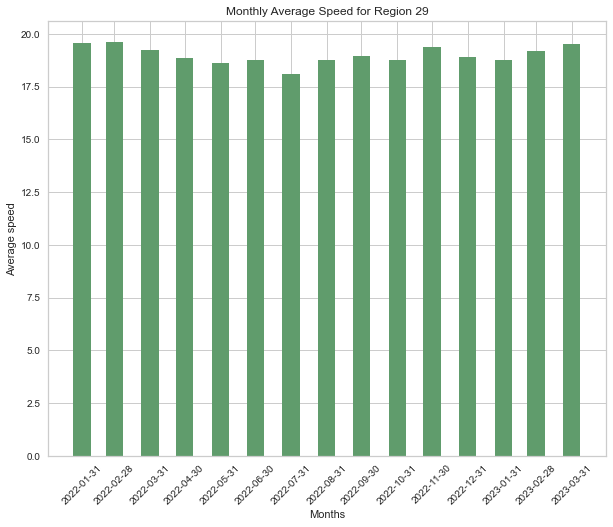

In [37]:
#region 29
plot_monthly_averages(region_29, 29)

#### Speed and Vehicle count

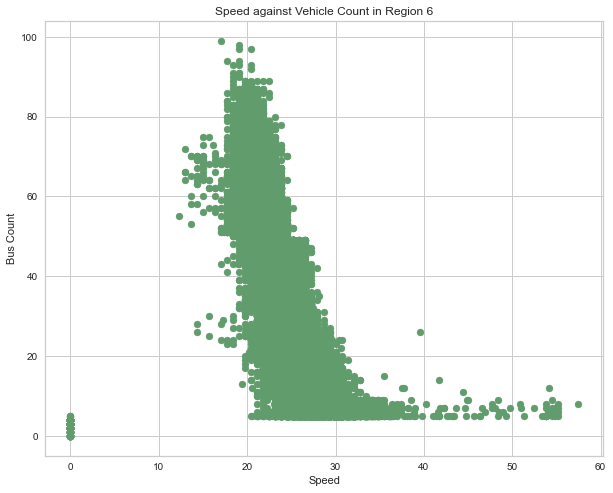

In [38]:
#Speed against Vehicle count for region 6
plt.figure(figsize=(10,8))
plt.title("Speed against Vehicle Count in Region 6")
plt.scatter(region_6.SPEED, region_6.BUS_COUNT, color="#609c6c")
plt.xlabel("Speed")
plt.ylabel("Bus Count")
plt.show()

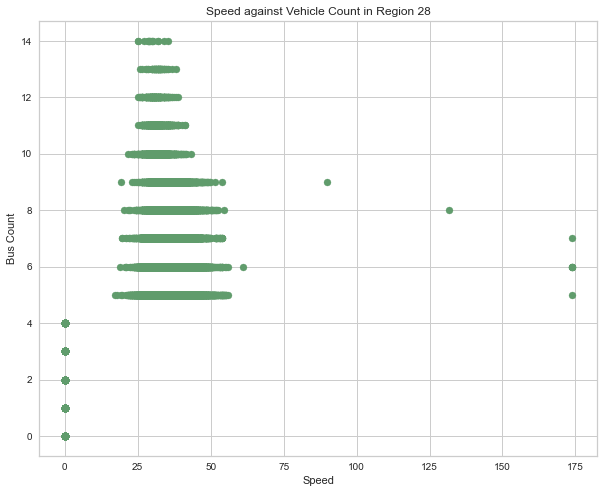

In [39]:
#Speed against Vehicle count for region 28
plt.figure(figsize=(10,8))
plt.title("Speed against Vehicle Count in Region 28")
plt.scatter(region_28.SPEED, region_28.BUS_COUNT, color="#609c6c")
plt.xlabel("Speed")
plt.ylabel("Bus Count")
plt.show()

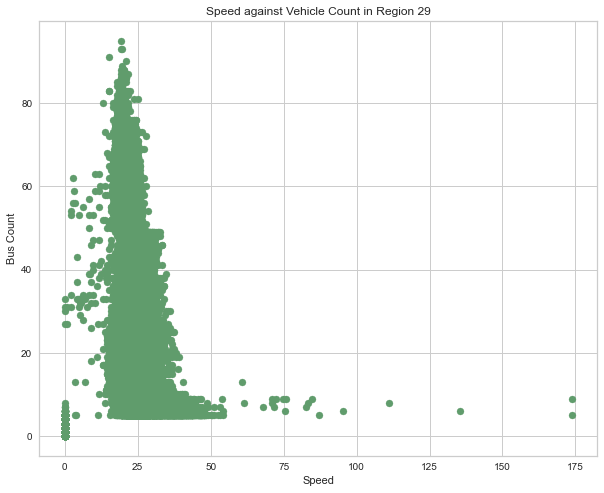

In [40]:
#Speed against Vehicle count for region 29
plt.figure(figsize=(10,8))
plt.title("Speed against Vehicle Count in Region 29")
plt.scatter(region_29.SPEED, region_29.BUS_COUNT, color="#609c6c")
plt.xlabel("Speed")
plt.ylabel("Bus Count")
plt.show()

#### Visualizations for the Bus Count variable

In [41]:
def plot_count_averages(region, n):
    averages=[]
    groups = region.groupby('HOUR')
    for i in np.arange(0,24):
        avg = groups.get_group(i).BUS_COUNT.mean()
        averages.append(avg)

    plt.figure(figsize=(10,8))
    plt.title(f"Hourly average bus count in Region {n}")
    sns.barplot(x=np.arange(0,24), y=averages, color="#609c6c")
    plt.xlabel("Hours")
    plt.ylabel("Average Bus Count")
    plt.show()

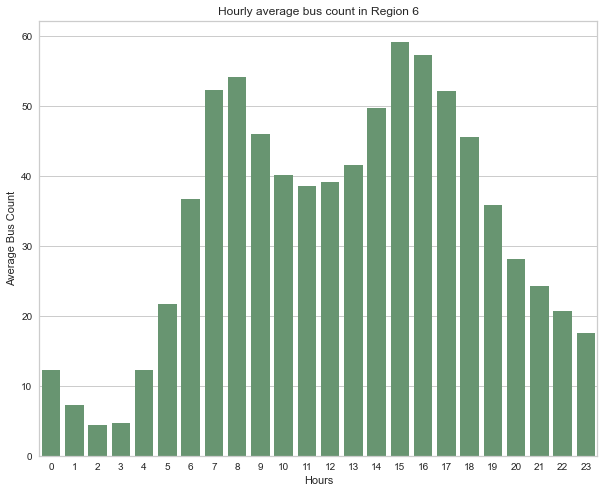

In [42]:
#Average Bus Count in region 6
plot_count_averages(region_6,6)

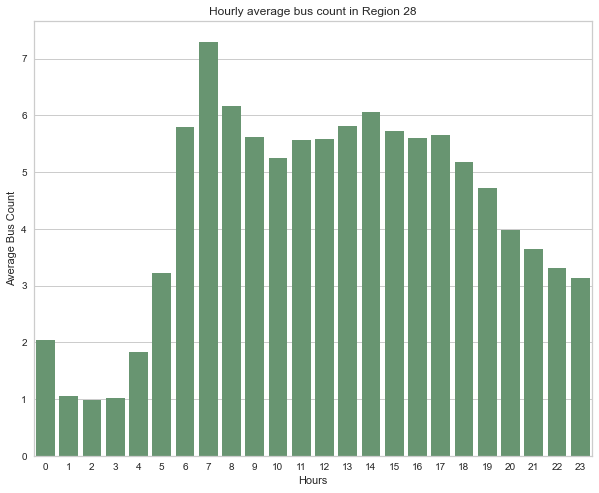

In [43]:
#Average Bus Count in region 6
plot_count_averages(region_28,28)

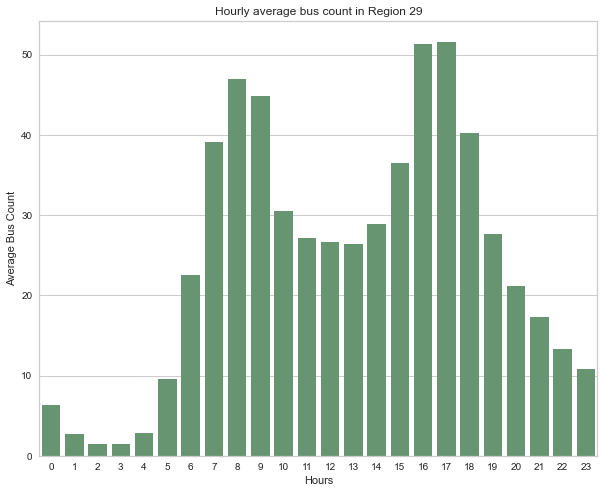

In [44]:
#Average Bus Count in region 6
plot_count_averages(region_29,29)

## II. Feature Engineering: Data Augmentation

> To build predictive models for the anlytics solution, a target feature is needed. A new column is derived based on the following description provided with the dataset:

>SPEED: Real-time estimated congestion level. Although expressed in miles per hour, this value is more a reflection of the congestion level in the region than it is indicative of the average raw speed vehicles are travelling within the region. For congestion advisory and traffic maps this value is compared to a ***0-9, 10-14, 15-19, 20-24, and 25 & over scale to display heavy, medium-heavy, medium, light and free flow conditions for the traffic region*** . Note that except for a very few segments, speed on city arterials is limited to 30 mph by ordinance. Occasionally, during the wee hours at night, an adequate number of GPS traces are not available for some traffic regions; and, hence, the traffic conditions for such regions are defaulted to 0 to reflect data unavailability.

In [45]:
#adding a target feature
def set_status(speed, num):
    if num == 0:
        return "Undetermined"
    elif speed >=0 and speed <=9:
        return "Heavy"
    elif speed >=10 and speed <=14:
        return "Medium heavy"
    elif speed >=15 and speed <=19:
        return "Medium"
    elif speed >=20 and speed <=24:
        return "Light"
    else:
        return "Free flow"

chicago_2022["STATUS"] = chicago_2022.apply(lambda row: set_status(row["SPEED"], row["NUM_READS"]), axis=1)

In [46]:
chicago_2022.STATUS.value_counts()

Free flow       1005424
Light            349917
Heavy            128593
Medium            40422
Undetermined       6871
Medium heavy        802
Name: STATUS, dtype: int64

In [47]:
chicago_2022

,REGION_ID,SPEED,REGION,BUS_COUNT,NUM_READS,HOUR,DAY_OF_WEEK,MONTH,WEST,EAST,SOUTH,NORTH,STATUS
TIME,,,,,,,,,,,,,
2022-01-01 00:01:21,15,33.41,Bridgeport-McKinley-Lower West,8,218,0,7,1,-87.685372,-87.636322,41.822792,41.866129,Free flow
2022-01-01 00:01:21,21,30.31,Hyde Park-Kenwood-Woodlawn,9,232,0,7,1,-87.606334,-87.566260,41.764066,41.822792,Free flow
2022-01-01 00:01:21,2,0.00,Far North West,2,42,0,7,1,-87.846210,-87.747456,41.960669,42.019100,Heavy
2022-01-01 00:01:21,6,26.59,Irving Park-Avondale-North Ctr,8,235,0,7,1,-87.747456,-87.674590,41.931841,41.960669,Free flow
2022-01-01 00:01:21,29,0.68,Downtown Lakefront,27,496,0,7,1,-87.623080,-87.595378,41.866129,41.911401,Heavy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-05 02:10:26,28,0.00,Riverdale-Hegewisch,2,64,2,1,3,-87.662508,-87.524436,41.644139,41.677477,Heavy
2023-03-05 02:10:26,26,39.55,Washington Hts-Roseland-Pullman,7,169,2,1,3,-87.662508,-87.584845,41.677477,41.728472,Free flow
2023-03-05 02:10:26,25,0.00,Beverly-Mt Greenwood-Morgan Park,1,7,2,1,3,-87.747456,-87.662508,41.677477,41.728472,Heavy


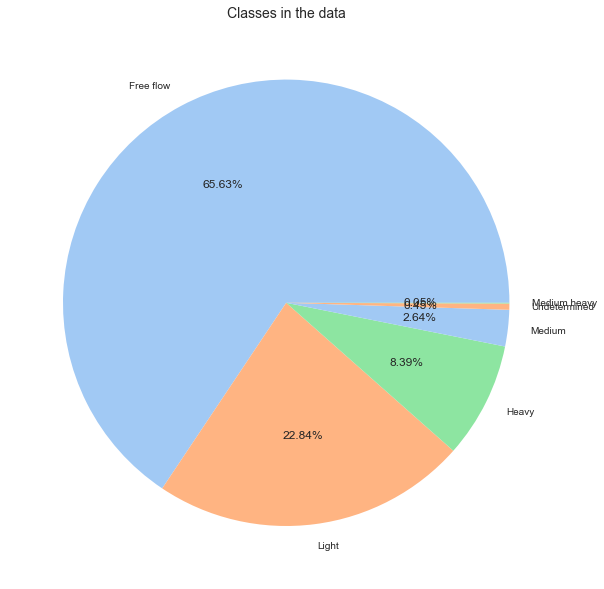

In [48]:
#Visualizing the congestion labels
plt.figure(figsize=(10,32))
colors = sns.color_palette('pastel')[0:3]
plt.title("Classes in the data", fontsize=14)
plt.pie(chicago_2022.STATUS.value_counts(), labels=['Free flow','Light','Heavy','Medium','Undetermined','Medium heavy'], colors=colors, autopct='%.2f%%')
plt.show()

## III. Unsupervised Learning: K Means Clustering

In [60]:
#dropping the region column and the augmented variable
chicago_new = chicago_2022.drop("REGION", axis=1)
chicago_new = chicago_new.iloc[:10000,:-1]

#standardizing the data
scaler = StandardScaler()
chicago_standardized = scaler.fit_transform(chicago_new)
chicago_standardized = pd.DataFrame(chicago_standardized, columns=chicago_new.columns)
chicago_standardized = chicago_standardized.set_index(chicago_new.index)

#### Determining the number of clusters

##### Silhouette plots

In [52]:
#Function to visualize silhouette plots
def silhouettePlot(data, k):
    visualizer = SilhouetteVisualizer(KMeans(n_clusters=k),colors='yellowbrick')
    visualizer.fit(data)
    visualizer.show()

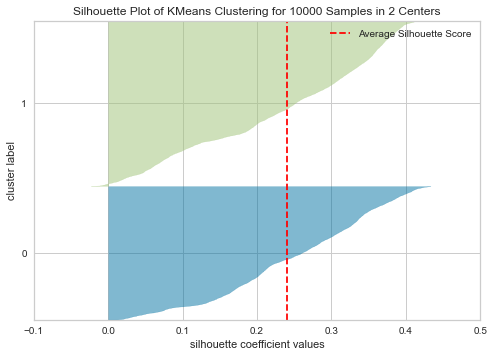

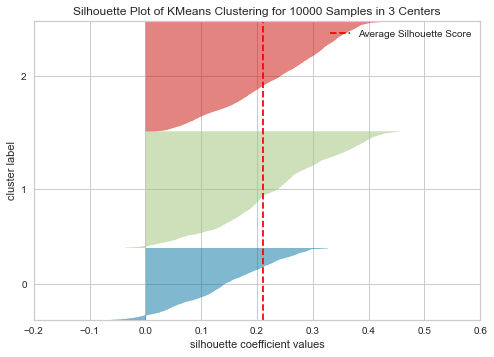

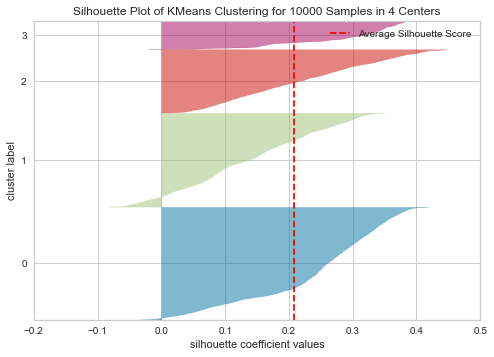

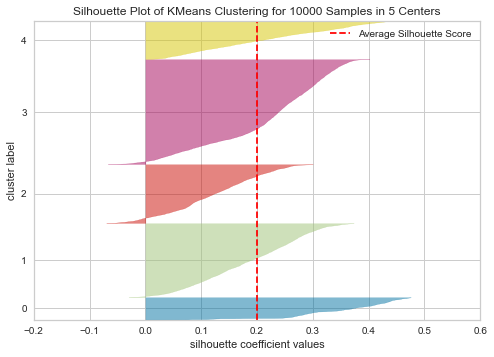

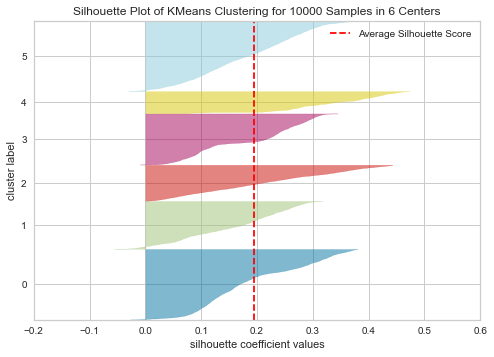

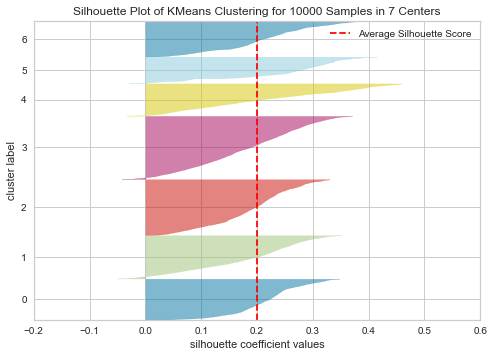

In [53]:
#visualizing silhouette plots
for i in range(2,8):
    silhouettePlot(chicago_standardized, i)

##### Elbow plots

In [56]:
#Function to visualize Elbow plots
def elbowPlot(data, metric):
    visualizer=KElbowVisualizer(KMeans(), k=(2,10), metric=metric, timings=True)
    visualizer.fit(data)
    visualizer.show()

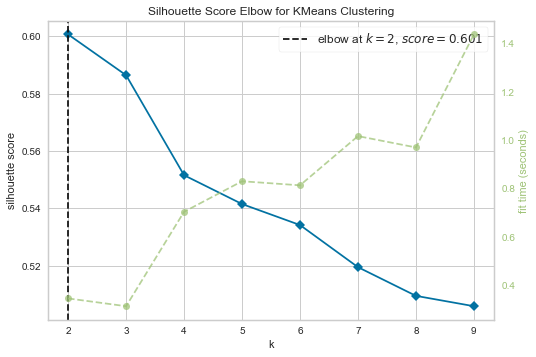

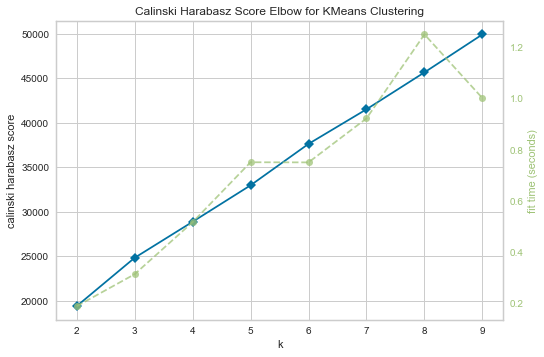

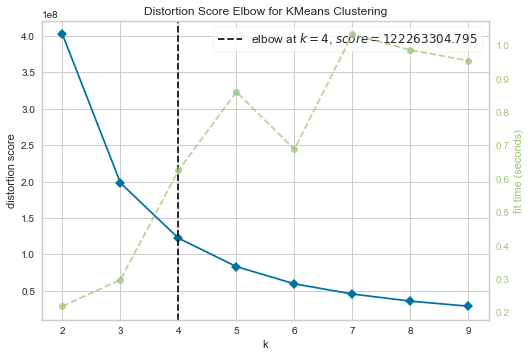

In [57]:
for metric in ["silhouette","calinski_harabasz","distortion"]:
    elbowPlot(chicago_new, metric)

> The above metrics might not be suitable for such time series data

#### Clustering

In [58]:
#function to perform clustering
def clustering(k):
    model = KMeans(n_clusters=k, random_state=42)
    cluster_labels = model.fit_predict(chicago_new)
    chicago_new["clusters"] = cluster_labels
    
    return model

In [59]:
for k in range(2,9):
    model = clustering(k)
    #Calculating silhouette_score
    print(f"For k={k} the silhouette score is {silhouette_score(chicago_new, model.labels_)}")

For k=2 the silhouette score is 0.600730280862535
For k=3 the silhouette score is 0.586488306672959
For k=4 the silhouette score is 0.5516277518104871
For k=5 the silhouette score is 0.5415135768330154
For k=6 the silhouette score is 0.5343346420350276
For k=7 the silhouette score is 0.5199490999838852
For k=8 the silhouette score is 0.5100503319013407


## IV. Feature Selection

In [61]:
#encoding the target variable
label_encoder = LabelEncoder()
chicago_2022["STATUS"]= label_encoder.fit_transform(chicago_2022["STATUS"])

### Using correlation

In [63]:
#correlation matrix
corr_matrix = chicago_2022.corr(numeric_only=True)
corr_matrix

,REGION_ID,SPEED,BUS_COUNT,NUM_READS,HOUR,DAY_OF_WEEK,MONTH,WEST,EAST,SOUTH,NORTH,STATUS
REGION_ID,1.000000,0.059993,-0.176388,-0.186576,-0.000022,0.000016,0.000074,0.556334,0.644409,-0.907738,-0.906584,-0.201629
SPEED,0.059993,1.000000,0.067846,0.105774,0.173798,0.009713,0.019473,-0.042830,-0.036274,-0.115642,-0.097340,-0.445754
BUS_COUNT,-0.176388,0.067846,1.000000,0.953853,0.263408,0.051100,0.001214,0.017597,-0.038314,0.189633,0.185977,0.367370
NUM_READS,-0.186576,0.105774,0.953853,1.000000,0.263025,0.049070,0.002017,-0.034357,-0.056731,0.144765,0.150639,0.290057
HOUR,-0.000022,0.173798,0.263408,0.263025,1.000000,-0.001790,0.000784,-0.000013,-0.000014,0.000019,0.000019,0.082296
DAY_OF_WEEK,0.000016,0.009713,0.051100,0.049070,-0.001790,1.000000,0.021877,0.000008,0.000017,-0.000014,-0.000014,0.020955
MONTH,0.000074,0.019473,0.001214,0.002017,0.000784,0.021877,1.000000,0.000038,0.000047,-0.000071,-0.000071,-0.030200
WEST,0.556334,-0.042830,0.017597,-0.034357,-0.000013,0.000008,0.000038,1.000000,0.924887,-0.369718,-0.397998,0.044862
EAST,0.644409,-0.036274,-0.038314,-0.056731,-0.000014,0.000017,0.000047,0.924887,1.000000,-0.516288,-0.549120,-0.021710
SOUTH,-0.907738,-0.115642,0.189633,0.144765,0.000019,-0.000014,-0.000071,-0.369718,-0.516288,1.000000,0.993417,0.291567


In [66]:
chicago_2022.drop("REGION", axis=1, inplace=True)
chicago_2022

,REGION_ID,SPEED,BUS_COUNT,NUM_READS,HOUR,DAY_OF_WEEK,MONTH,WEST,EAST,SOUTH,NORTH,STATUS
TIME,,,,,,,,,,,,
2022-01-01 00:01:21,15,33.41,8,218,0,7,1,-87.685372,-87.636322,41.822792,41.866129,0
2022-01-01 00:01:21,21,30.31,9,232,0,7,1,-87.606334,-87.566260,41.764066,41.822792,0
2022-01-01 00:01:21,2,0.00,2,42,0,7,1,-87.846210,-87.747456,41.960669,42.019100,1
2022-01-01 00:01:21,6,26.59,8,235,0,7,1,-87.747456,-87.674590,41.931841,41.960669,0
2022-01-01 00:01:21,29,0.68,27,496,0,7,1,-87.623080,-87.595378,41.866129,41.911401,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-05 02:10:26,28,0.00,2,64,2,1,3,-87.662508,-87.524436,41.644139,41.677477,1
2023-03-05 02:10:26,26,39.55,7,169,2,1,3,-87.662508,-87.584845,41.677477,41.728472,0
2023-03-05 02:10:26,25,0.00,1,7,2,1,3,-87.747456,-87.662508,41.677477,41.728472,1


<AxesSubplot:>

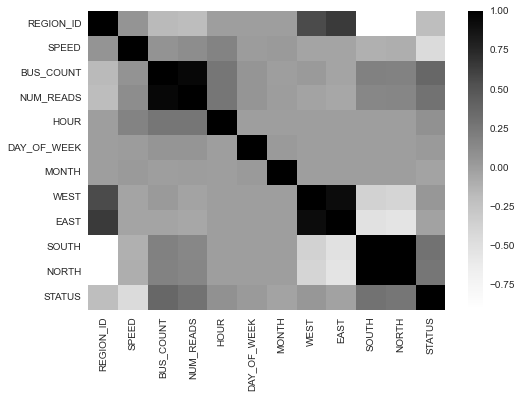

In [67]:
#visualizing the correlation matrix
sns.heatmap(corr_matrix, cmap='Greys')

### Using PCA

In [78]:
#fitting PCA on standardized data
pca = PCA(random_state=42)
components = pca.fit(chicago_standardized, chicago_2022["STATUS"])

In [79]:
components.explained_variance_ratio_.cumsum()

array([0.38379945, 0.59832342, 0.71337857, 0.81533143, 0.90009957,
       0.9795612 , 0.99076124, 0.99574206, 0.99951942, 1.        ,
       1.        ])

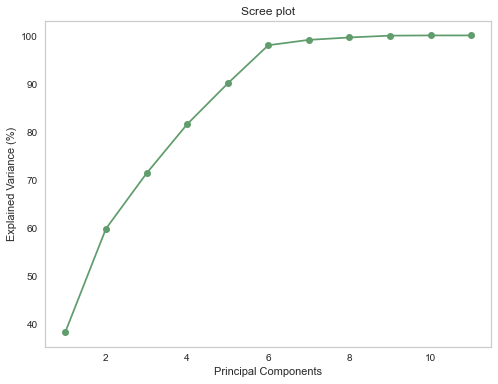

In [81]:
#scree plot
plt.figure(figsize=(8,6))
plt.title("Scree plot")
plt.plot(range(1,12), components.explained_variance_ratio_.cumsum()*100, "-o", color='#609c6c')
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance (%)")
plt.grid()
plt.show()